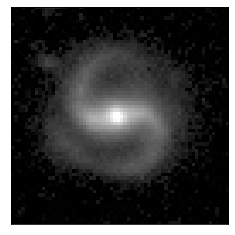

In [9]:
""" Overlay a single mask on respective image """

import matplotlib.pyplot as plt
from PIL import Image

IMG_FILE = r"E:\Documents\Thesis\spiral-galaxies\data\Tadaki_Segmentation\set_1\orig_images\42261258421956171.jpg"
MSK_FILE = r"E:\Documents\Thesis\spiral-galaxies\data\Tadaki_Segmentation\set_1\segmentation\42261258421956171.tif"

img = Image.open(IMG_FILE)
msk = Image.open(MSK_FILE)

plt.imshow(img, cmap='gray')
#plt.imshow(msk, cmap='gnuplot', alpha=0.2)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()